# Figure 8 - HNSC case study

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

/var/folders/r7/35dx8vvn5mj7qlgb03v4gl5h0000gn/T/ipykernel_61892/3036222232.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('../cluster_compute/data/TCGA-HNSC.csv', index_col=[0])
data = data.loc[~data.index.duplicated()]

GENE1 = 'RPA1'
GENE2 = 'RPA2'
GENE3 = 'RPA3'
data[f'{GENE1}-{GENE2}'] = data[GENE1] - data[GENE2]
data[f'{GENE1}-{GENE3}'] = data[GENE1] - data[GENE3]
data[f'{GENE2}-{GENE3}'] = data[GENE2] - data[GENE3]

## Radiotherapy effect

In [3]:
meta = pd.read_csv('metadata/HNSC_data_clinical_patient.txt', sep='\t', index_col=0, skiprows=4)
meta = meta.loc[~meta.index.duplicated()]
meta.columns

Index(['SUBTYPE', 'CANCER_TYPE_ACRONYM', 'OTHER_PATIENT_ID', 'AGE', 'SEX',
       'AJCC_PATHOLOGIC_TUMOR_STAGE', 'AJCC_STAGING_EDITION',
       'DAYS_LAST_FOLLOWUP', 'DAYS_TO_BIRTH',
       'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', 'ETHNICITY',
       'FORM_COMPLETION_DATE', 'HISTORY_NEOADJUVANT_TRTYN', 'ICD_10',
       'ICD_O_3_HISTOLOGY', 'ICD_O_3_SITE', 'INFORMED_CONSENT_VERIFIED',
       'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT', 'PATH_M_STAGE',
       'PATH_N_STAGE', 'PATH_T_STAGE', 'PERSON_NEOPLASM_CANCER_STATUS',
       'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT', 'PRIOR_DX', 'RACE',
       'RADIATION_THERAPY', 'WEIGHT', 'IN_PANCANPATHWAYS_FREEZE', 'OS_STATUS',
       'OS_MONTHS', 'DSS_STATUS', 'DSS_MONTHS', 'DFS_STATUS', 'DFS_MONTHS',
       'PFS_STATUS', 'PFS_MONTHS', 'GENETIC_ANCESTRY_LABEL'],
      dtype='object')

In [4]:
d = pd.concat((meta[['RADIATION_THERAPY', 'SUBTYPE']], data), axis=1).dropna()
d['RT'] = d['RADIATION_THERAPY'].isin(['Yes']).astype(float)
d['HPV'] = d['SUBTYPE'].isin(['HNSC_HPV+']).astype(float)
d = d.sort_values(by='RPA2-RPA3', ascending=False)
d = d[d['RT'] ==1]

Text(0.49, 0.44, 'd)')

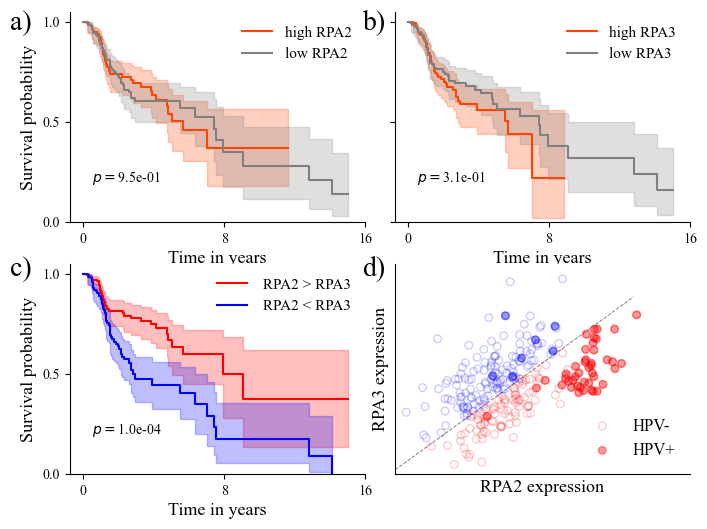

In [5]:
plt.rcParams["font.family"] = "Times New Roman"

f, axes = plt.subplots(2, 2, figsize=(8,6), gridspec_kw={'wspace':0.1})

y_c = d[['time', 'event']]

for ax, gene in zip([axes[0][0], axes[0][1], axes[1][0]], ["RPA2", "RPA3", "RPA2-RPA3"]):
    
    c1 = d[gene].values > np.median(d[gene].values)

    kmf_control = KaplanMeierFitter()
    kmf_control.fit(y_c.loc[c1]['time'], y_c.loc[c1]["event"], label=f"{'high' if gene != 'RPA2-RPA3' else ''} {gene.replace('-', ' > ')}").plot_survival_function(ax=ax, color="red" if gene == 'RPA2-RPA3' else 'orangered')

    kmf_exp = KaplanMeierFitter()
    kmf_exp.fit(y_c.loc[~c1]['time'], y_c.loc[~c1]["event"], label=f"{'low' if gene != 'RPA2-RPA3' else ''} {gene.replace('-', ' < ')}").plot_survival_function(ax=ax, color="gray" if gene != 'RPA2-RPA3' else 'blue')

    ax.legend(frameon=False, fontsize=11)
    ax.set_xlabel("Time in years", fontsize=13)
    ax.set_ylim(0.0, 1.05)

    ax.set_ylabel("Survival probability", fontsize=13)
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])

    for loc in ["top", "right"]:
        ax.spines[loc].set_visible(False)

    logrank = logrank_test(y_c.loc[c1]['time'], y_c.loc[~c1]['time'], y_c.loc[c1]["event"], y_c.loc[~c1]["event"])

    YEAR = 365
    ax.text(0.5*YEAR, 0.2, f"$p =${logrank.p_value:.1e}")

axes[0][1].set_yticklabels(["", "", ""])
axes[0][1].set_ylabel("", fontsize=13)

for i,j in [(0,0), (0,1), (1,0)]:
    axes[i][j].set_xticks([0, 365*8, 365*16])
    axes[i][j].set_xticklabels([0, 8, 16])

# scatter

genes = "RPA2*RPA3".split("*")
gene = "RPA2-RPA3"
ALPHA = 0.2

c1 = d[gene].values > np.median(d[gene].values)
sc = axes[1][1].scatter(d[genes[0]], d[genes[1]], edgecolors=[(1,0,0,ALPHA) if x else (0,0,1,ALPHA) for x in c1], facecolors=(0,0,0,0), s=30, label='HPV-')
#sc.set_edgecolorsalpha(0.3)

ALPHA = 0.4
c1 = pd.Series(d[gene].values > np.median(d[gene].values), index=d.index)
c2 = d['HPV'] == 1
sc = axes[1][1].scatter(d.loc[c2][genes[0]], d.loc[c2][genes[1]], c=[(1,0,0,ALPHA) if x else (0,0,1,ALPHA) for x in c1.loc[c2]], s=30, label='HPV+')

axes[1][1].set_xlabel(f"{genes[0]} expression", fontsize=13)
axes[1][1].set_ylabel(f"{genes[1]} expression", fontsize=13)

axes[1][1].set_xticks([])
axes[1][1].set_yticks([])

axes[1][1].legend(fontsize=12, frameon=False)

for loc in ["top", "right"]:
    axes[1][1].spines[loc].set_visible(False)

axes[1][1].plot([0.1])
xlim, ylim = axes[1][1].get_xlim(), axes[1][1].get_ylim()
med = np.median(d["RPA2-RPA3"].values)
axes[1][1].plot([-4, 3], [-4-med, 3-med],ls="--", color="gray", lw=0.7, zorder=0)
axes[1][1].set_xlim(xlim[0], xlim[1]+1)
axes[1][1].set_ylim(ylim[0], ylim[1]*1.05)

f.text(0.05, 0.85, "a)", fontsize=20)
f.text(0.49, 0.85, "b)", fontsize=20)

f.text(0.05, 0.44, "c)", fontsize=20)
f.text(0.49, 0.44, "d)", fontsize=20)

#f.savefig('figures/figure8_HNSC-case-study-RPA.pdf', dpi=300, bbox_inches='tight', transparent=True)